# Text-To-Speech using Tacotron 2

In [1]:
# When running this notebook you need to install the below libraries
# ! pip3 install deep_phonemizer
# ! pip install torchaudio

We will build a text-to-speech pipeline, using the pretrained Tacotron 2 in torchaudio.


In [1]:
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
import IPython

matplotlib.rcParams['figure.figsize'] = [16.0,4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.10.2
0.10.2
cpu


## 1. Text Preprocessing

### Character-based Encoding

The input text  is encoded into a list of symbols, using enlgish characters and phenemes as the symbols. We define a set of symbols e.g. *'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'*. Then, we will map each character to the matching symbol in the table

In [2]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Testing this out!"
print(text_to_sequence(text))

[31, 16, 30, 31, 20, 25, 18, 11, 31, 19, 20, 30, 11, 26, 32, 31, 2]


The symbol table must match the pretrained Tacotron2 model expects. torchaudio provides the transform along with the pretrained model, e.g. you can instantiate and transform as below

In [3]:
def character_encoding(text):
    
    processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
    processed, lengths = processor(text)
    
    return processor, processed, lengths

In [50]:
text = "Testing this out!"
processor, processed, lengths = character_encoding(text)
print(f"Processed string : {processed}")
print(f"Length : {lengths}")

Processed string : tensor([[31, 16, 30, 31, 20, 25, 18, 11, 31, 19, 20, 30, 11, 26, 32, 31,  2]])
Length : tensor([17], dtype=torch.int32)


The processor object takes either text of list of texts as inputs. When a list of text is provided, the return lengths represents the valid length of each processed token in the output batch.

The intermediate representation can be retrieved as follows:

In [51]:
def intermediate(processor,processed):
    print([processor.tokens[i] for i in processed[0, :lengths[0]]])

In [52]:
intermediate(processor,processed)

['t', 'e', 's', 't', 'i', 'n', 'g', ' ', 't', 'h', 'i', 's', ' ', 'o', 'u', 't', '!']


## Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding with the exception that is uses a symbol table based on phonemes and a Grapheme-to-Phoneme(G2P) model.

Similar to character-based encoding, the encoding process is expected to match what a pretrained Tacotron2 model is trained on. **torchaudio** has an interface the create the process and the below code demonstrates this.

In [53]:
def phoneme_encoding(text):

    processor = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_text_processor()

    with torch.inference_mode():
        processed, lengths = processor(text)
    
    return processor, processed, lengths  

In [54]:
text = "We are at this again!"
processor, processed, lengths = phoneme_encoding(text)
print(f"Processed string : {processed}")
print(f"Length : {lengths}")

Processed string : tensor([[92, 59, 11, 12, 78, 11, 16, 81, 11, 39, 55, 79, 11, 20, 53, 40, 67,  2]])
Length : tensor([18], dtype=torch.int32)


We notice that the phoneme-based encoded values are different from the character-based encoded values.

The intermediate representation looks like the following:

In [55]:
intermediate(processor,processed)

['W', 'IY', ' ', 'AA', 'R', ' ', 'AE', 'T', ' ', 'DH', 'IH', 'S', ' ', 'AH', 'G', 'EH', 'N', '!']


## 2. Spectrogram Generation

From the encoded text, a spectogram is generated using the **Tacotron2** model. We retrieve the pretrained weights and additional data to be used with Tacotron2 through the use of **tochaudio.pipelines.Tacotron2TTSBundle**.

In [9]:
def spectogram(bundle, text):

    processor = bundle.get_text_processor()
    tacotron2 = bundle.get_tacotron2().to(device)

    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        
    return spec, spec_lengths

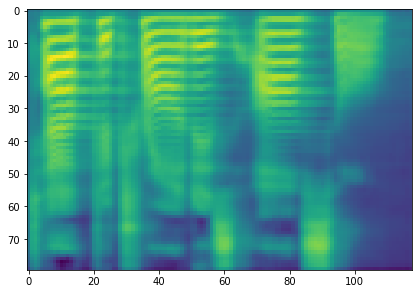

In [10]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
text = "Tacotron is awesome!"
spec, spec_lengths = spectogram(bundle,text)
plt.imshow(spec[0].cpu().detach())

# 3. Waveform Generation

We convert the spectogram into the waveform. The process to generate from speech to spectogram is call Vocoder, in this notebook we use the following vocoders: 
- WaveRNN
- Griffin-Lim
- Nvidia's WaveGlow

**torchaudio** provides vocoders baseed on **GriffinLim** and **WaveRNN**

In [22]:
def wavey(bundle,text,device):
    
    processor = bundle.get_text_processor()
    tacotron2 = bundle.get_tacotron2().to(device)
    vocoder =  bundle.get_vocoder().to(device)
    
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed,lengths)
    waveforms, lengths = vocoder(spec,spec_lengths)
        
    return vocoder, spec, waveforms

In [23]:
def plot_spec(spec, waveforms):
    fig, [ax1,ax2] = plt.subplots(2,1,figsize=(16,9))
    ax1.imshow(spec[0].cpu().detach())
    ax2.plot(waveforms[0].cpu().detach())

In [ ]:
def speech(waveforms,vocoder=None,text):
    torchaudio.save(text, waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
    return IPython.display.Audio(text)

### WaveRNN

We use the WaveRNN speech to text vocoder 

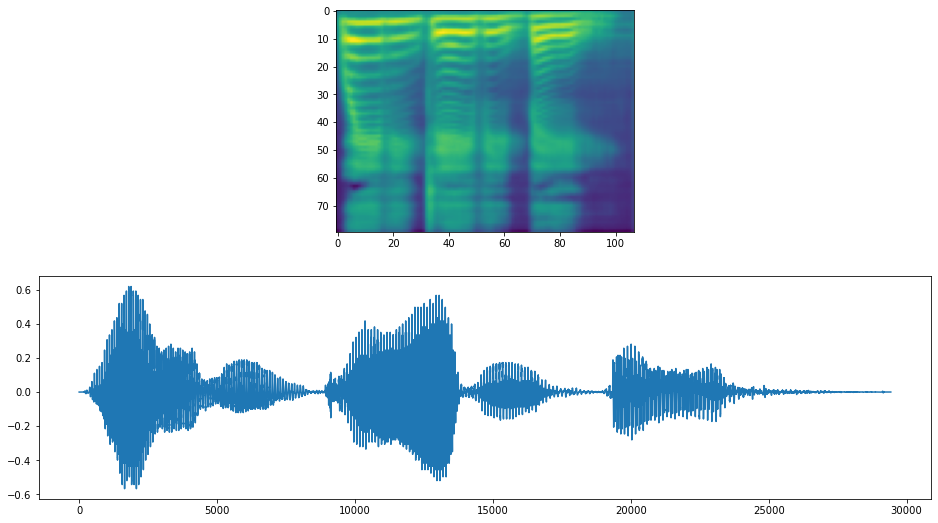

In [25]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
text  = "Wavy davy baby!"
vocoder, spec, waveforms = wavey(bundle,text,device)
plot_spec(spec,waveforms)

In [30]:
# saving the output as a wav file
speech(waveforms, vocoder, "output_wavernn.wav")

### Griffin-Lim

We use the Griffin-Lim speech to text vocoder

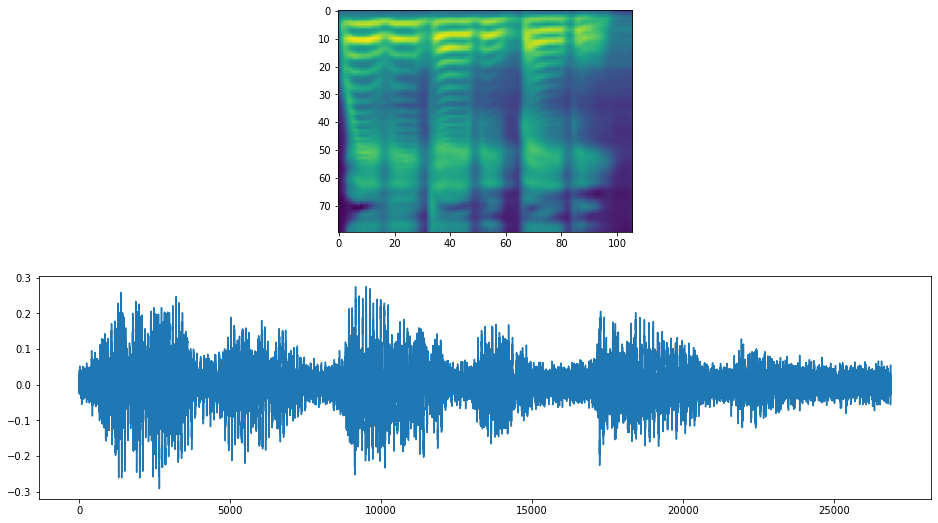

In [27]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
text  = "Wavy davy baby!"
vocoder, spec, waveforms = wavey(bundle,text,device)
plot_spec(spec,waveforms)

In [31]:
speech(waveforms, vocoder, "output_griffinlim.wav")

### Waveglow

We use the wagelow speech to text vocoder by Nvidia

In [41]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 
                          'nvidia_waveglow', model_math='fp32', pretrained=False)
checkpoint = torch.hub.load_state_dict_from_url(
    'https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth', 
    progress=False, map_location=device)


Using cache found in /Users/khanyisilesixhaxa/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [42]:
state_dict = {key.replace("module.", ""): value for key,
              value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)
    

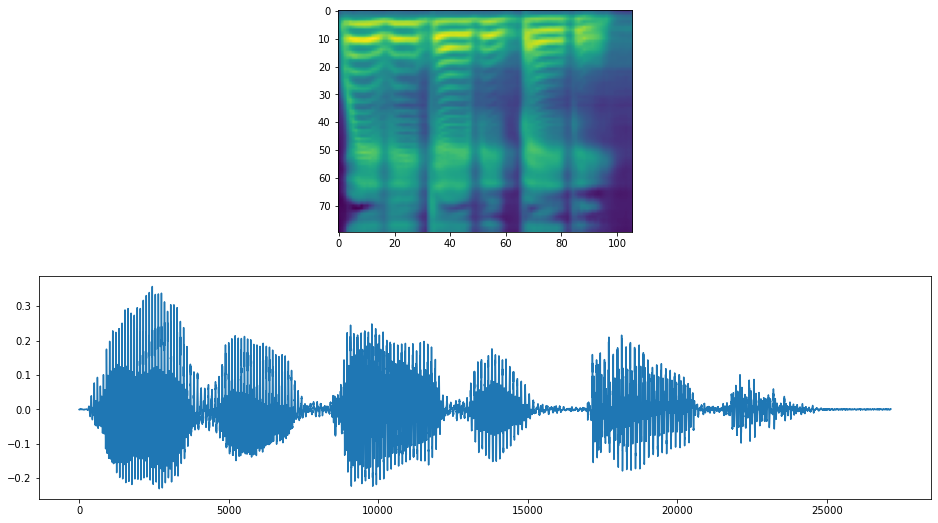

In [43]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

In [46]:
torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.Audio("output_waveglow.wav")